In [2]:
# original size 258866 # 258841 # 258816
import sys
import os
from torch.utils.data import DataLoader
sys.path.append("..")
from tqdm import tqdm
import shutil
import torch
import numpy as np
import pandas as pd

from utils import train_test_split, create_metadata_df
from dataset_xy import CARLADatasetXY
from data_preprocessing import preprocessing
import json
from send2trash import send2trash

/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path_data = os.path.join("..", "..", "data", "data")

config_xy = {"used_inputs": ["rgb", "measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "y": ["brake", "steer", "throttle"],
        "seq_len": 1
        }

# Create df_meta 
# df_meta_data = create_metadata_df(path_data, config_xy["used_inputs"])
df_meta_data = pd.read_pickle("df_meta_data.pickle")


# Create Dataset & DataLoader
dataset = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data, config=config_xy)

In [4]:
dl = DataLoader(dataset=dataset, batch_size=64, num_workers=0, sampler=None, shuffle=False)

In [5]:
df_measurements = pd.read_pickle("df_measurements.pickle")

## Create distributions for entire dataset

array([[<AxesSubplot: title={'center': 'speed'}>,
        <AxesSubplot: title={'center': 'command'}>],
       [<AxesSubplot: title={'center': 'steer'}>,
        <AxesSubplot: title={'center': 'throttle'}>]], dtype=object)

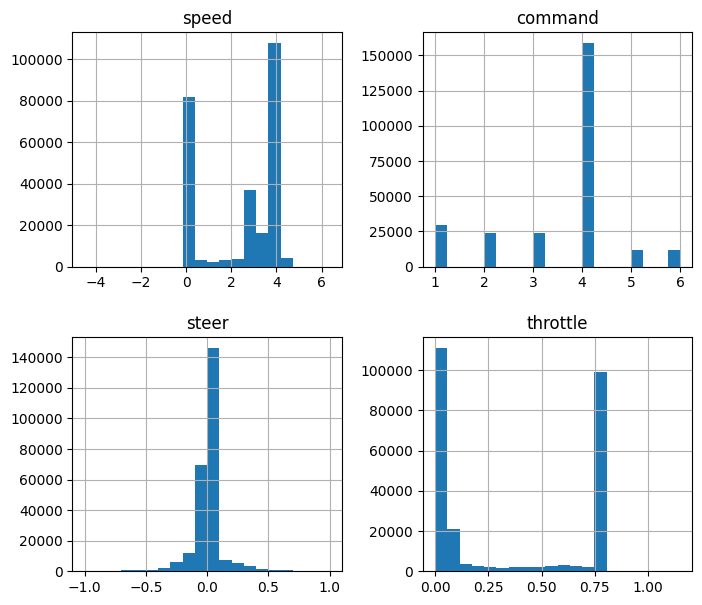

In [6]:
df_measurements.hist(figsize=(8, 7), bins=20)

## Create distributions for train and test set separately (they should be similar)

In [7]:
df_meta_data_train, df_meta_data_test = train_test_split(df_meta_data, towns_no_intersect={"train": ["Town04"], "test": ["Town05"]}) # "Town06"
df_meta_data_test = df_meta_data_test.sample(n=int(df_meta_data_train.shape[0] * 0.15), random_state=3)



# train_test_config = {
#     "train": ['Town00', 'Town01', 'Town02', 'Town03', 'Town04', 'Town05', 'Town07', 'Town08', 'Town09', 'Town10'],
#     "test": ['Town06']
# }
# df_meta_data_train, df_meta_data_test_1, df_meta_data_test_2 = train_test_split(df_meta_data, towns_intersect=train_test_config)


In [8]:
#df_meta_data.to_pickle("df_meta_data.pickle")
# df_measurements.to_json("df_measurements.json")
# df_meta_data.to_json("df_meta_data.json")

array([[<AxesSubplot: title={'center': 'speed'}>,
        <AxesSubplot: title={'center': 'command'}>],
       [<AxesSubplot: title={'center': 'steer'}>,
        <AxesSubplot: title={'center': 'throttle'}>]], dtype=object)

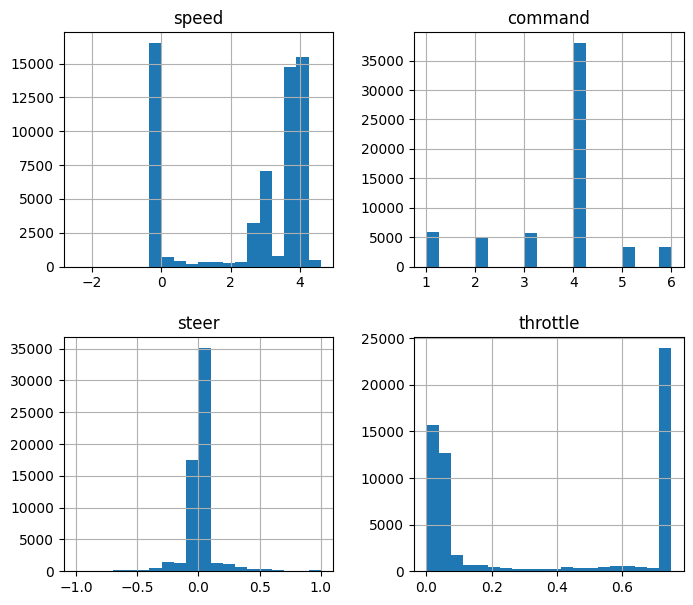

In [9]:
df_measurements_train = df_measurements[df_measurements.index.isin(df_meta_data_train.index)]
df_measurements_train.hist(figsize=(8, 7), bins=20)

array([[<AxesSubplot: title={'center': 'speed'}>,
        <AxesSubplot: title={'center': 'command'}>],
       [<AxesSubplot: title={'center': 'steer'}>,
        <AxesSubplot: title={'center': 'throttle'}>]], dtype=object)

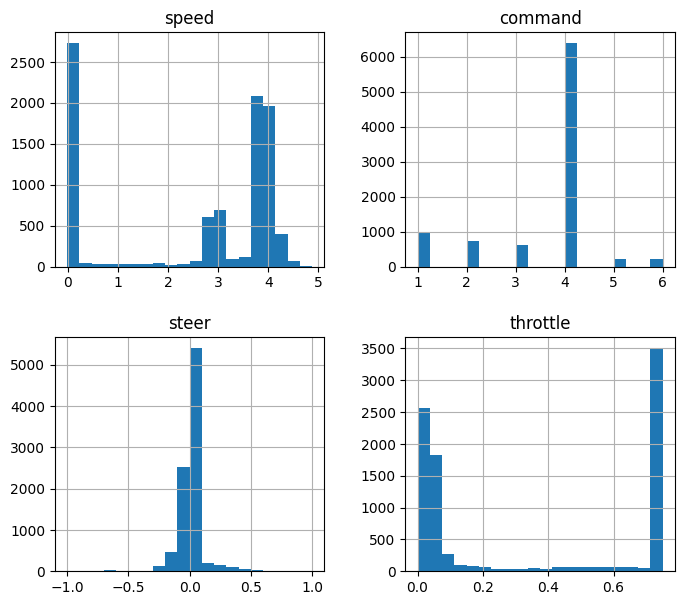

In [10]:
df_measurements_test = df_measurements[df_measurements.index.isin(df_meta_data_test.index)]
df_measurements_test.hist(figsize=(8, 7), bins=20)

In [11]:
df_measurements.describe()

,speed,command,steer,throttle
count,2.588160e+05,258816.000000,258816.000000,258816.000000
mean,2.382342e+00,3.521227,0.000917,0.347406
std,1.724863e+00,1.216411,0.127009,0.346908
min,-4.490779e+00,1.000000,-1.000000,0.000000
25%,5.878689e-08,3.000000,-0.005500,0.000000
50%,3.082393e+00,4.000000,0.000000,0.105180
75%,3.861653e+00,4.000000,0.002000,0.750000
max,6.353220e+00,6.000000,1.000000,1.150000


## Creating classes using histograms & first weight calculations

In [83]:
num_classes = 5
hist, bin_edges = np.histogram(df_measurements["steer"], bins=num_classes)
# Edges in which to classify
bin_edges[-1] = 1.1

In [99]:
bin_edges

array([-1. , -0.6, -0.2,  0.2,  0.6,  1.1])

In [91]:
# Assign each sample a steer class
bin_mapping = np.digitize(df_measurements["steer"], bins=bin_edges,)
# Count to make sure that counts match with the results given by np.histograms()
bin_mapping_count = pd.DataFrame(bin_mapping).value_counts(normalize=True).sort_index().values
bin_mapping_count

array([0.00429649, 0.03683312, 0.90908986, 0.04510154, 0.004679  ])

In [98]:
np.digitize([0, -0.5,], bins=bin_edges,)

array([3, 2])

In [92]:
# Each sample gets the it's class likelihood assigned (num_classes is used to match the definition of the corresponding sklearn function)
bin_mapping_weighted = num_classes * bin_mapping_count[bin_mapping-1]
# Inverse is taken
bin_mapping_weighted = 1 / (bin_mapping_weighted)
bin_mapping_weighted

array([0.22000026, 0.22000026, 0.22000026, ..., 0.22000026, 0.22000026,
       0.22000026])

In [103]:
# Compute unique for training notebook

# Each sample gets the it's class likelihood assigned (num_classes is used to match the definition of the corresponding sklearn function)
bin_mapping_weighted = num_classes * bin_mapping_count
# Inverse is taken
bin_mapping_weighted = 1 / (bin_mapping_weighted)
bin_mapping_weighted

array([46.54964029,  5.42989615,  0.22000026,  4.43443845, 42.74417836])

In [96]:
bin_mapping_count

array([0.00429649, 0.03683312, 0.90908986, 0.04510154, 0.004679  ])

In [34]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

In [36]:
# If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)) = len(bin_mapping) / (5 * np.bincount(bin_mapping))
class_weights = compute_class_weight(classes=np.unique(bin_mapping), y=bin_mapping, class_weight="balanced")
# The “balanced” mode uses the values of y to automatically adjust weights inversely proportional 
# to class frequencies in the input data: n_samples / (n_classes * np.bincount(y))
sample_weights = compute_sample_weight(y=bin_mapping, class_weight="balanced")

In [102]:
np.unique(sample_weights, return_index=True, return_counts=True)

(array([ 0.22000026,  4.43443845,  5.42989615, 42.74417836, 46.54964029]),
 array([   0,   89,   44, 1283, 9805]),
 array([235287,  11673,   9533,   1211,   1112]))

In [94]:
sample_weights

array([0.22000026, 0.22000026, 0.22000026, ..., 0.22000026, 0.22000026,
       0.22000026])

In [95]:
class_weights

array([46.54964029,  5.42989615,  0.22000026,  4.43443845, 42.74417836])

In [55]:
len(bin_mapping) / (5 * np.bincount(bin_mapping))

/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_19167/1074231576.py:1: RuntimeWarning: divide by zero encountered in divide
  len(bin_mapping) / (5 * np.bincount(bin_mapping))


array([        inf, 46.54964029,  5.42989615,  0.22000026,  4.43443845,
       42.74417836])

In [90]:
np.bincount(bin_mapping)

array([     0,   1112,   9533, 235287,  11673,   1211])